<a href="https://www.kaggle.com/code/minhjuniordinh/machine-learning-review-1?scriptVersionId=294757643" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

For context, this is a jupyter notebook exercise where I learn sklearn, concepts of overfitting, crossvalidation, regularisation and when to use bayes vs logistic regression. 

# Section 1 Model Selection and Model Complexity

In [1]:
# Import all libraries used
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator 
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

## Question 1 (KNN Regressor)
### Part 1.
Implement a KNN regressor using the scikit-learn conventions, i.e., in a class

In [2]:
class KnnRegressor(BaseEstimator):
    def __init__(self, num_neighbors=5):
        """
        KNN Regressor using KDTree for efficient neighbor searches
        Params:
           num_neighbors: int, number of neighbors to use for prediction, default 5
        """
        self.num_neighbors = num_neighbors

    def fit(self, train_data, train_targets):
        """
        Fit the model using train_data as training data and train_targets as target values
        Params:
          train_data: (array) Training data
          train_targets: (array) Target values
        """
        # Validate the input data and output targets
        train_data, train_targets = check_X_y(train_data, train_targets)
        # Store the training targets
        self.train_targets_ = train_targets
        # Build a KDTree for efficient neighbor search
        self.kd_tree_ = KDTree(train_data)
        return self

    def predict(self, test_data):
        """
        Predict the target values for the provided data
        Params:
          test_data: (array) Test samples
        Returns:
          predictions: (array) Predicted target values
        """
        # Ensure the model is fitted before prediction so self.kd_tree doesn't raise error
        check_is_fitted(self)
        # Validate the test data, ensures 2D without NaNs 
        test_data = check_array(test_data)
        # Query the KDTree to find the nearest neighbors
        distances, neighbor_indices = self.kd_tree_.query(test_data, k=self.num_neighbors)

        # Handle case when num_neighbors=1 (returns 1D array)
        # If only 1 neighbor requested, makes sure neighbor_indices is 2D 
        if self.num_neighbors == 1:
            neighbor_indices = neighbor_indices.reshape(-1, 1)

        # Get the corresponding target values and compute the mean for each test sample
        return self.train_targets_[neighbor_indices].mean(axis=1)

In [3]:
diabetes_data = load_diabetes()
features, targets = diabetes_data.data, diabetes_data.target
# target is the true output values (labels) for each example

# training and test 70/30 split
features_train, features_test, targets_train, targets_test = train_test_split(features, targets, test_size=0.3, random_state=83)
# features_train evaluates training accuracy
# features_test evaluates generalisation on unseen data 

# Initialise -> fit the KNN regressor with 5 neighbors
knn_model = KnnRegressor(num_neighbors=5) # create instance with 5 neighbors
knn_model.fit(features_train, targets_train)

# Do train and test data predictions
train_predictions = knn_model.predict(features_train)
test_predictions = knn_model.predict(features_test)

# Use MSE to calculate error for train and test pred
train_mse = mean_squared_error(targets_train, train_predictions)
test_mse = mean_squared_error(targets_test, test_predictions)

# Show errors
print(f"MSE for Train Error: {train_mse:.2f}")
print(f"MSE for Test Error: {test_mse:.2f}")

MSE for Train Error: 2437.62
MSE for Test Error: 3499.84


***

## Question 2 (L-fold Cross Validation)
### Part 1.
Using the scikit-learn convention for data splitters, implement a L-Fold Cross Validation (CV) scheme

In [4]:
class LFold:
    def __init__(self, num_splits=5, shuffle=False, random_seed=83):
        """
        L-Fold Cross-Validation iterator
        Params:
          num_splits : int, default=5 (Number of folds. Must be at least 2)
          shuffle : bool, default=False (Whether to shuffle the data before splitting into folds)
          random_seed : int or None, default=None (Random seed for shuffling)
        """
        if num_splits < 2:
            raise ValueError("Number of splits must be at least 2")
        self.num_splits = num_splits
        self.shuffle = shuffle
        self.random_seed = random_seed

    def get_n_splits(self, x=None, y=None, groups=None):
        """
        Returns the number of splitting iterations in the cross-validator.
        """
        return self.num_splits

    def split(self, data, y=None, groups=None):
        """
        Generate indices to split data into training and test set.
        Params:
          data: (array) Data to split
          y: None - for compatibility
          groups: None - for compatibility
        Yields:
          train_indices: ndarray (Training set indices for that split)
          test_indices : ndarray (The testing set indices for that split)
        """
        # Data -> numpy array conversion
        data = np.asarray(data) # ensures nparray 
        num_samples = len(data) # total data pts - to cal fold sizes 
        indices = np.arange(num_samples)

        # If needed, shuffle indices
        if self.shuffle:
            rng = np.random.RandomState(self.random_seed)
            rng.shuffle(indices)

        # Size of each fold determination
        fold_sizes = np.full(self.num_splits, num_samples // self.num_splits, dtype=int)
        fold_sizes[:num_samples % self.num_splits] += 1
        # calculates the ideal number of samples for each fold 
        # calculates leftover data points and first few folds are given an extra data point

        # Do indices for train & test for each fold
        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            test_indices = indices[start:stop]
            train_indices = np.concatenate([indices[:start], indices[stop:]])
            yield train_indices, test_indices
            current = stop
        
      # test_indices is set to start-stop 
      # train_indices is everything else
      # yield makes the function a generator to make series of train-test splits for each fold wo storing in memory


In [5]:
# Testing Lfold using a list of 20 integers with shuffling 
print("5 folds on range(20):")
for train_indices, test_indices in LFold(5, shuffle=True).split(list(range(20))):
    print(f"Train: {train_indices}, Test: {test_indices}")

5 folds on range(20):
Train: [ 2 17  5 15 11 14  4 10 12  3 19 16  0  7  8 18], Test: [13  9  1  6]
Train: [13  9  1  6 11 14  4 10 12  3 19 16  0  7  8 18], Test: [ 2 17  5 15]
Train: [13  9  1  6  2 17  5 15 12  3 19 16  0  7  8 18], Test: [11 14  4 10]
Train: [13  9  1  6  2 17  5 15 11 14  4 10  0  7  8 18], Test: [12  3 19 16]
Train: [13  9  1  6  2 17  5 15 11 14  4 10 12  3 19 16], Test: [ 0  7  8 18]


***

### Part 2.
For the dataset from Question 1, use your L-fold CV implementation to systematically test
the effect of the KNN parameter K by testing all options from 1 to 30 and, for each K, instead
of only performing a single training/test split run your L-Fold CV. For each K compute the
mean and standard deviation of the mean squared error (training and test) across the L folds
and report the K for which you found the best test performance.

In [6]:
def evaluate_knn_with_cv(X, y, k_values=range(1, 31), num_folds=5, shuffle=True, random_seed=83):
    '''
    evaluates knn regressors for different 
    values of k using the Lfold cross-validator.
    Loops over k values 1-30, for each each k:
        Trains KNN on training split
        Tests on validation split 
        Computes MSE 
    Aggregates mean and SD across folds 
    Params:
        X: features matrix 2d feature-sample rows 
        y: target vector 1d
    Returns:
        results: dict 
    '''
    results = {
        'k': [],
        'train_mean_mse': [],
        'train_std_mse': [],
        'test_mean_mse': [],
        'test_std_mse': [],
        'num_folds': num_folds
    }
    
    cv = LFold(num_folds, shuffle=shuffle, random_seed=random_seed)
    
    for k in k_values:
        train_mses = []
        test_mses = []
        
        # Perform L-fold cross-validation
        for train_idx, test_idx in cv.split(X): # Split the dataset into training and validation folds
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            knn = KnnRegressor(num_neighbors=k)
            knn.fit(X_train, y_train)
            
            train_mses.append(mean_squared_error(y_train, knn.predict(X_train)))
            test_mses.append(mean_squared_error(y_test, knn.predict(X_test)))
        
        results['k'].append(k)
        results['train_mean_mse'].append(np.mean(train_mses))
        results['train_std_mse'].append(np.std(train_mses))
        results['test_mean_mse'].append(np.mean(test_mses))
        results['test_std_mse'].append(np.std(test_mses))
    
    return results

In [7]:
def plot_knn_cv_results(results, title=None):
    '''
    generates plot of k vs MSE to visualise 
    overfitting, underfitting and optimal k
    '''
    k_vals = results['k']
    L = results['num_folds']
    
    # Compute 95% confidence intervals
    train_se = 1.96 * np.array(results['train_std_mse']) / np.sqrt(L)
    test_se = 1.96 * np.array(results['test_std_mse']) / np.sqrt(L)
    
    plt.figure(figsize=(10, 6))
    plt.errorbar(k_vals, results['train_mean_mse'], yerr=train_se, label='Train MSE (95% CI)', fmt='-o')
    plt.errorbar(k_vals, results['test_mean_mse'], yerr=test_se, label='Test MSE (95% CI)', fmt='-o')
    
    plt.xlabel('K (Number of Neighbors)')
    plt.ylabel('Mean Squared Error')
    plt.title(title or 'KNN Regression with 95% Confidence Intervals')
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
# Single train/test split (outer split) - 70% training, 30% test
X_train, X_test, y_train, y_test = train_test_split(
    features, targets,
    test_size=0.3,
    random_state=83
)

# Create the cross-validator instance with 5 neighbors 
cv = LFold(num_splits=5, shuffle=True, random_seed=83)
# training data will be split into 5 folds

best_k = None
best_cv_mse = float('inf')

# Candidate K values
candidate_ks = list(range(1, 30))

for k in candidate_ks:
    fold_mses = []
    
    for train_idx, val_idx in cv.split(X_train):
        x_train_fold, x_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        # each fold created

        # Train a KNN on the fold
        knn_model = KnnRegressor(num_neighbors=k)
        knn_model.fit(x_train_fold, y_train_fold)
        
        # Predict and evaluate on the validation fold
        val_predictions = knn_model.predict(x_val_fold)
        mse = mean_squared_error(y_val_fold, val_predictions)
        fold_mses.append(mse)
    
    mean_mse = np.mean(fold_mses)
    
    # Update the best k if this k is better
    if mean_mse < best_cv_mse:
        best_cv_mse = mean_mse
        best_k = k

print(f"Best k found from inner CV: {best_k}")

Best k found from inner CV: 17


In [9]:
# Train final model with best K
final_knn_model = KnnRegressor(num_neighbors=best_k)
final_knn_model.fit(X_train, y_train)

KnnRegressor(num_neighbors=17)

In [10]:
# Predictions on both train and test
train_predictions = final_knn_model.predict(X_train)
test_predictions = final_knn_model.predict(X_test)

# Compute MSE
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

# Compute standard deviations
train_squared_errors = (y_train - train_predictions) ** 2
test_squared_errors = (y_test - test_predictions) ** 2

train_std = np.std(train_squared_errors, ddof=1)
test_std = np.std(test_squared_errors, ddof=1)

# Show results
print("Single train/test split results:")
print(f"   Chosen best k (inner CV): {best_k}")
print(f"   Train MSE: {train_mse:.2f} ± {train_std:.2f}")
print(f"   Test  MSE: {test_mse:.2f} ± {test_std:.2f}")


Single train/test split results:
   Chosen best k (inner CV): 17
   Train MSE: 2744.71 ± 3662.52
   Test  MSE: 3670.76 ± 4607.21


Large sd - potential for outlier sensitivity

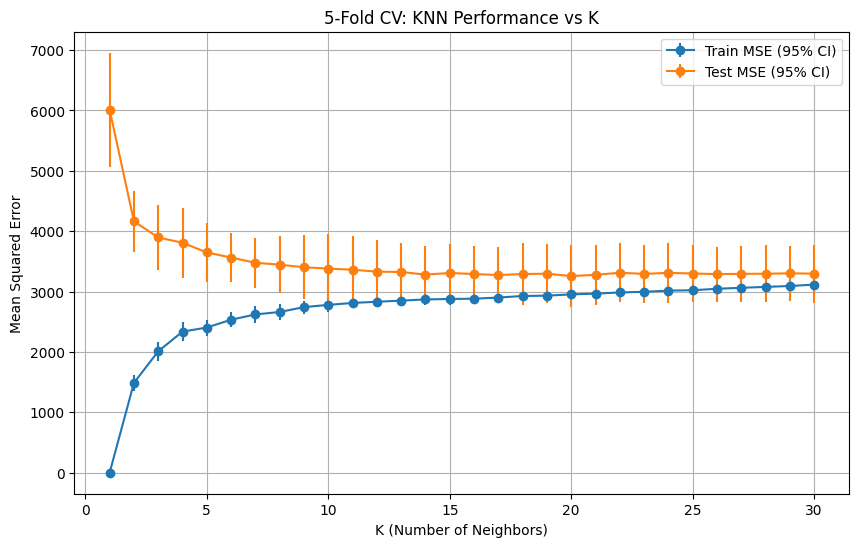

In [11]:
# Evaluate for default num_folds = 5
results_5fold = evaluate_knn_with_cv(features, targets, num_folds=5, shuffle=True)
plot_knn_cv_results(results_5fold, title="5-Fold CV: KNN Performance vs K")

***

### Part 3.
For the dataset diabetes, plot the mean training and test errors against the choice of K with error bars (that represent 95%-confidence intervals). You can compute the confidence
intervals as:

$m ± 1.96s/√L$

where m is the sample mean and s is the sample standard deviation of the error across the L folds (the quantity $s/√L$ is also referred to as the standard error of the mean). Based on this plot, comment on:

* The effect of the parameter K. For the dataset diabetes, identify regions of overfitting
and underfitting for the KNN model.
* The effect of the parameter L of the CV procedure.


Fold of 3


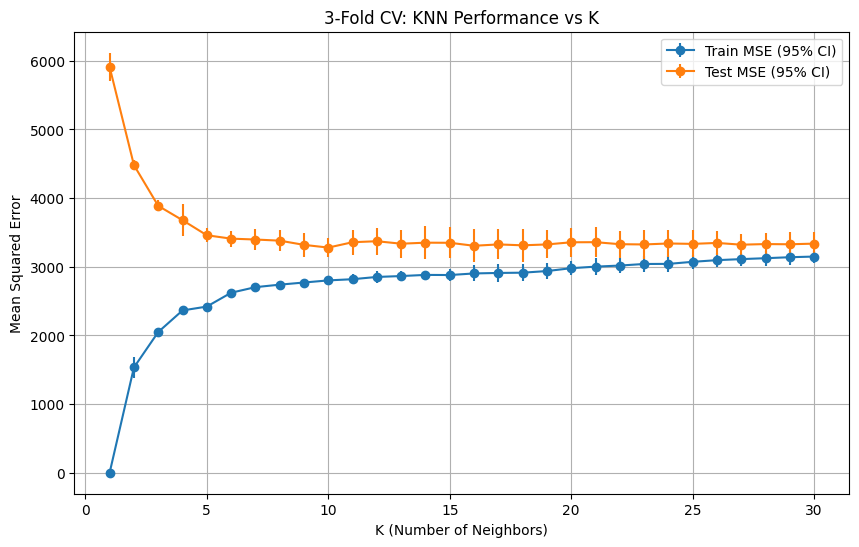


--------------------------------------------------
Fold of 6


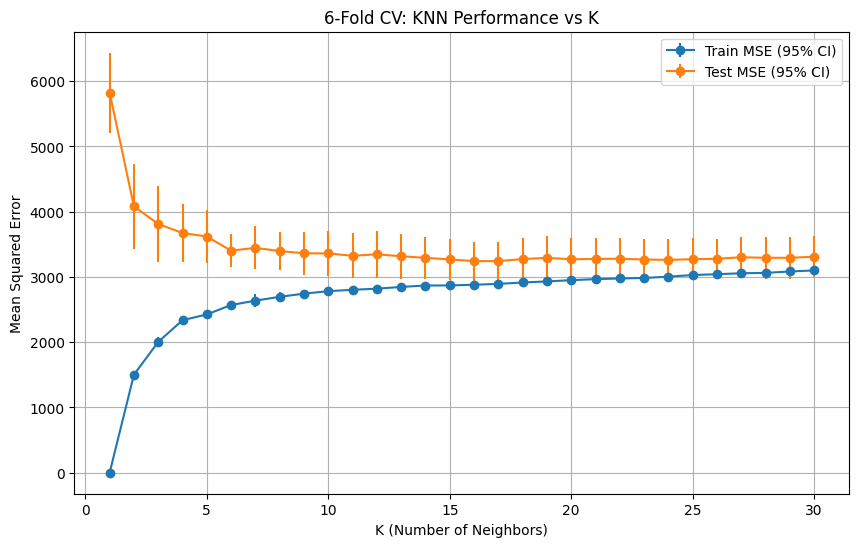


--------------------------------------------------
Fold of 9


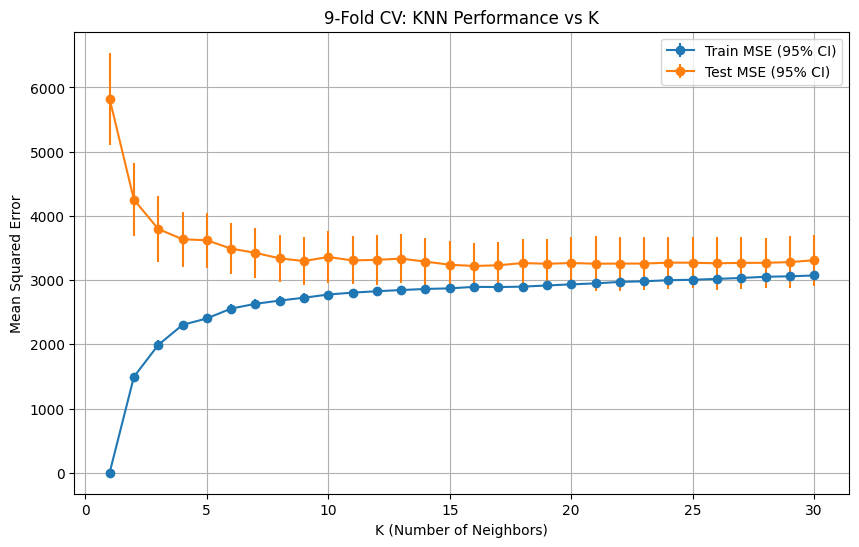


--------------------------------------------------
Fold of 15


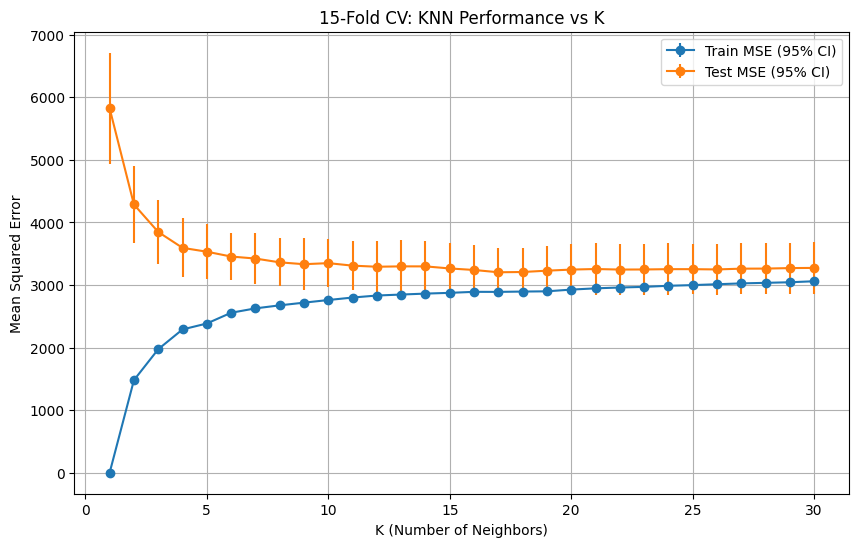


--------------------------------------------------
Fold of 30


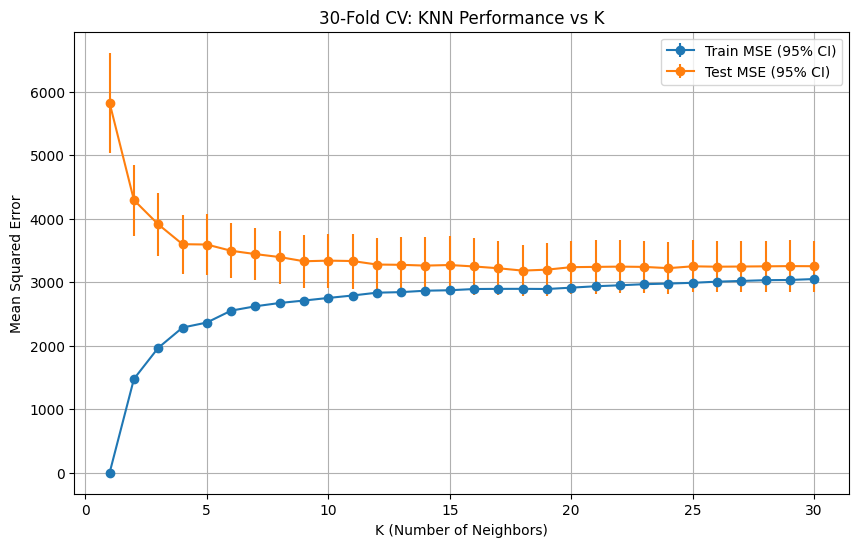


--------------------------------------------------
Fold of 60


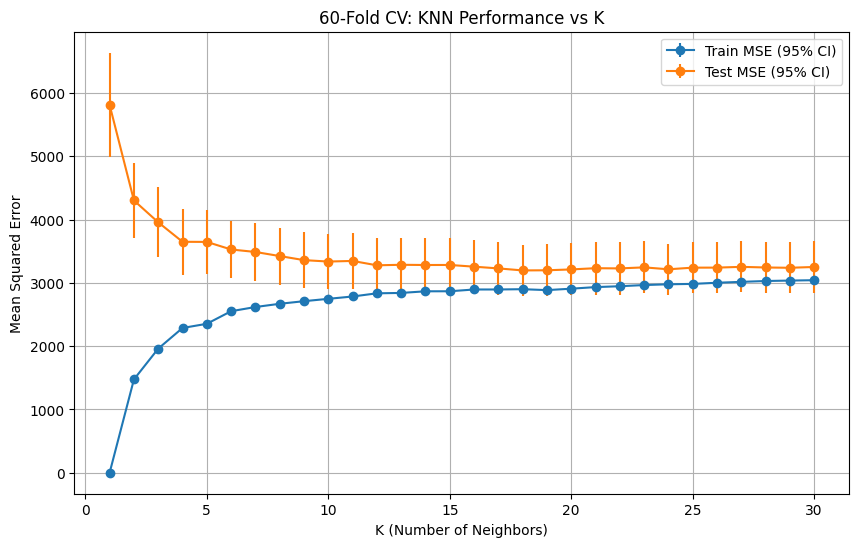


--------------------------------------------------
Fold of 100


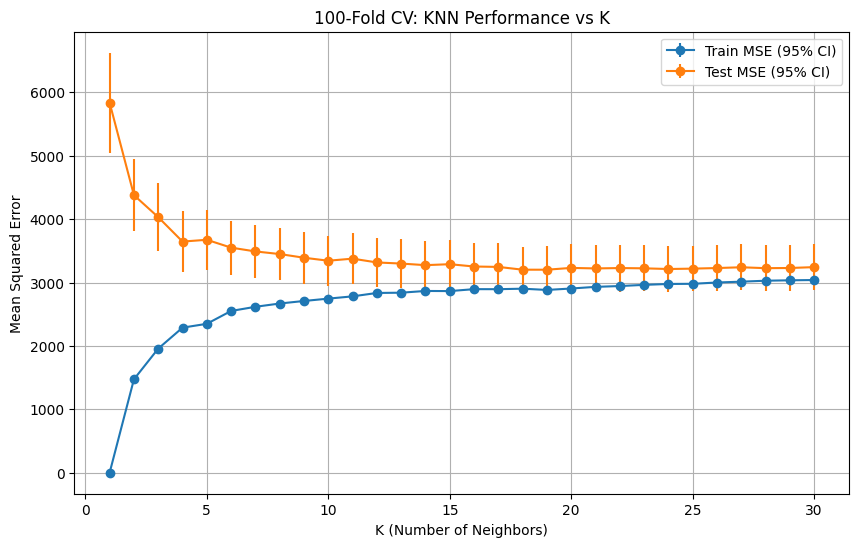

In [12]:
# Evaluate for different values of num_folds
print('Fold of 3')
results_3fold = evaluate_knn_with_cv(features, targets, num_folds=3)
plot_knn_cv_results(results_3fold, title="3-Fold CV: KNN Performance vs K")
print('\n--------------------------------------------------')

print('Fold of 6')
results_6fold = evaluate_knn_with_cv(features, targets, num_folds=6)
plot_knn_cv_results(results_6fold, title="6-Fold CV: KNN Performance vs K")
print('\n--------------------------------------------------')

print('Fold of 9')
results_9fold = evaluate_knn_with_cv(features, targets, num_folds=9)
plot_knn_cv_results(results_9fold, title="9-Fold CV: KNN Performance vs K")
print('\n--------------------------------------------------')

print('Fold of 15')
results_15fold = evaluate_knn_with_cv(features, targets, num_folds=15)
plot_knn_cv_results(results_15fold, title="15-Fold CV: KNN Performance vs K")
print('\n--------------------------------------------------')

print('Fold of 30')
results_30fold = evaluate_knn_with_cv(features, targets, num_folds=30)
plot_knn_cv_results(results_30fold, title="30-Fold CV: KNN Performance vs K")
print('\n--------------------------------------------------')

print('Fold of 60')
results_60fold = evaluate_knn_with_cv(features, targets, num_folds=60)
plot_knn_cv_results(results_60fold, title="60-Fold CV: KNN Performance vs K")
print('\n--------------------------------------------------')

print('Fold of 100')
results_100fold = evaluate_knn_with_cv(features, targets, num_folds=100)
plot_knn_cv_results(results_100fold, title="100-Fold CV: KNN Performance vs K")

#### Effect of K, the Number of Neighbors
* K controls the flexibility of the model.
* A **smaller K** (1-5) makes a model highly flexible **(overfitting, low train error, high test error)**
* A **higher K** appeared to make the model more generalisable shown by a lower test error and higher train error.
* A K too high could underfit and make the model too simple.
* In the graph above, the optimal K ranged from 10 to 19 across the different fold values.
* harder to see the bias-variance trade-off in the graph above to pick an optimal k, however, if a higher k was picked it could be seen (U-shaped testing error).

#### Effect of L, the Number of Folds
* L, the number of CV folds also changes the stableness and accuracy of error bars.
* A higher L means more training data per fold, which improves training accuracy error bars (lower deviation).
  * This can be seen in a fold of 3 easily were error bars tended to be below 20.
* But, the test MSE became very variable with a higher L, seen in the fold of 100, where test error bars tended to be around 2000.
  * This is because each test fold is smaller and more sensitive to data variation, leading to higher uncertainty.

#### It's about striking a balance for K and L values
We need to balance flexibility and generalisability when picking K. For choosing L it's about the bias-variance tradeoff. L values between 10-30 appeared to strike a good balance, having enough traning data and test data.


***

## Question 3 (Automatic Model Selection)
### Part 1.
Implement a version of the KNN regressor that automatically chooses an appropriate value of
K from a list of options by performing a cross-validation on the training set at fitting time.
As usual, use the scikit-learn paradigm.


In [13]:
# KNN Regressor with Cross-Validation for K selection
class KnnRegressorCV(BaseEstimator):
    def __init__(self, candidate_ks=list(range(1, 21)), cross_validator=LFold(5)):
        """
        KNN regressor with automatic K selection via internal cross-validation.
        Params:
            candidate_ks : list of int - candidate values of K to try
            cross_validator : LFold - cross-validator object
        """
        self.candidate_ks = candidate_ks
        self.cross_validator = cross_validator

    def fit(self, train_data, train_targets):
        # Validate the input data and targets
        train_data, train_targets = check_X_y(train_data, train_targets)
        self.train_data_ = train_data
        self.train_targets_ = train_targets

        best_k = None
        best_score = float('inf')

        # Cross-validate for each K
        for k in self.candidate_ks:
            test_mses = []

            # Perform cross-validation for current k
            for train_indices, test_indices in self.cross_validator.split(train_data): # splits the training data into folds using Lfold obkect
                data_train, data_val = train_data[train_indices], train_data[test_indices]
                targets_train, targets_val = train_targets[train_indices], train_targets[test_indices]
                # extracts current training and validation subsets for this fold 
                
                # Initialise and fit the KNN regressor
                knn = KnnRegressor(num_neighbors=k)
                knn.fit(data_train, targets_train) # feature and target passed to fit 
                val_predictions = knn.predict(data_val) # make predictions 
                mse = mean_squared_error(targets_val, val_predictions)
                test_mses.append(mse)

            # Calculate mean MSE and update best K if necessary
            mean_mse = np.mean(test_mses)
            if mean_mse < best_score:
                best_score = mean_mse
                best_k = k

        # Store the best K and fit the model with it
        self.best_k_ = best_k
        self.best_model_ = KnnRegressor(num_neighbors=self.best_k_)
        self.best_model_.fit(train_data, train_targets)
        return self

    def predict(self, test_data):
        # Ensure the model is fitted before prediction
        check_is_fitted(self, ['best_model_'])
        # Validate the test data
        test_data = check_array(test_data)
        # Predict using the best model
        return self.best_model_.predict(test_data)

### Part 2.
 For the dataset diabetes from the previous questions, test your KNN regressor with internal
CV by using either an outer single train/test-split or, ideally, with an outer cross-validation
(resulting in a so-called nested cross-validation scheme). See Fig. 1 for a further explanations.
Report on the (mean) k value that is chosen by the KNN regressor with internal crossvalidation and whether it corresponds to the best k-value with respect to the outer test
sets. Comment on what factors determine whether the internal cross-validation procedure is
successful in approximately selecting the best model.

In [14]:
# Single train/test split (outer split) - 70% training, 30% test
X_train, X_test, y_train, y_test = train_test_split(
    features, targets,
    test_size=0.3,
    random_state=83
)

# Fit KNN regressor with internal CV
knn_cv = KnnRegressorCV(candidate_ks=list(range(1, 21)))
knn_cv.fit(X_train, y_train)

# Predictions
train_predictions = knn_cv.predict(X_train)
test_predictions = knn_cv.predict(X_test)

# Compute MSE
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

# Compute ±1 standard deviation for train/test squared errors
train_squared_errors = (y_train - train_predictions)**2
test_squared_errors  = (y_test  - test_predictions)**2

train_std = np.std(train_squared_errors, ddof=1)
test_std  = np.std(test_squared_errors,  ddof=1)

# Show results
print("Single train/test split results:")
print(f"   Chosen best k (inner CV): {knn_cv.best_k_}")
print(f"   Train MSE: {train_mse:.2f}  ± {train_std:.2f}")
print(f"   Test  MSE: {test_mse:.2f}   ± {test_std:.2f}")

Single train/test split results:
   Chosen best k (inner CV): 15
   Train MSE: 2773.06  ± 3795.96
   Test  MSE: 3700.66   ± 4735.24


In [15]:
# Outer fold sizes to test
outer_folds_list = [3, 4, 5, 6, 7, 8, 9]

# Store results
nested_results = {}

# Perform nested cross-validation
# divides data into outer folds 
for outer_folds in outer_folds_list:
    outer_cv = LFold(num_splits=outer_folds, shuffle=True, random_seed=83)
    selected_ks = []
    test_mses = []

    
    for train_indices, test_indices in outer_cv.split(features):
        features_train, features_test = features[train_indices], features[test_indices]
        targets_train, targets_test   = targets[train_indices], targets[test_indices]

        # Fit the KNN regressor with internal CV - pick best k for each outer fold
        knn_cv = KnnRegressorCV(candidate_ks=list(range(1, 21)))
        knn_cv.fit(features_train, targets_train)

        # Predict on the outer test fold - outer CV validation
        test_predictions = knn_cv.predict(features_test)
        mse = mean_squared_error(targets_test, test_predictions)

        # Store the selected K and test MSE
        selected_ks.append(knn_cv.best_k_)
        test_mses.append(mse)

    mean_test_mse = np.mean(test_mses)
    std_test_mse = np.std(test_mses, ddof=1)

    # Store the results
    nested_results[outer_folds] = {
        'mean_selected_k': np.mean(selected_ks),
        'selected_ks': selected_ks,
        'mean_test_mse': mean_test_mse,
        'std_test_mse': std_test_mse,
        'test_mses': test_mses
    }

# Print results of nested cross-validation
print("Nested Cross-Validation Results:")
for folds, result in nested_results.items():
    print(f"Outer folds: {folds}")
    print(f"  Mean selected k: {result['mean_selected_k']:.2f}")
    print(f"  Mean test MSE: {result['mean_test_mse']:.2f} ± {result['std_test_mse']:.2f}")
    print(f"  Selected Ks per fold: {result['selected_ks']}")
    print()

Nested Cross-Validation Results:
Outer folds: 3
  Mean selected k: 16.33
  Mean test MSE: 3364.83 ± 222.30
  Selected Ks per fold: [15, 19, 15]

Outer folds: 4
  Mean selected k: 15.75
  Mean test MSE: 3358.79 ± 244.74
  Selected Ks per fold: [15, 19, 13, 16]

Outer folds: 5
  Mean selected k: 14.20
  Mean test MSE: 3286.22 ± 580.40
  Selected Ks per fold: [15, 18, 11, 13, 14]

Outer folds: 6
  Mean selected k: 16.50
  Mean test MSE: 3363.59 ± 370.85
  Selected Ks per fold: [20, 19, 20, 9, 15, 16]

Outer folds: 7
  Mean selected k: 14.00
  Mean test MSE: 3294.43 ± 706.16
  Selected Ks per fold: [16, 13, 14, 13, 15, 13, 14]

Outer folds: 8
  Mean selected k: 14.88
  Mean test MSE: 3270.33 ± 582.68
  Selected Ks per fold: [16, 13, 15, 15, 13, 15, 16, 16]

Outer folds: 9
  Mean selected k: 14.89
  Mean test MSE: 3263.88 ± 622.65
  Selected Ks per fold: [17, 14, 14, 14, 14, 15, 15, 15, 16]



### Single Train/Test Split (Outer Split)
- The best k picked (for inner CV): 15  
- Test MSE: approx 3700.66  

Only a certain k-value of 15 was given (70/30 train/test split), but doesn't confirm how well this k generalises to other data splits.

### Nested Cross-Validation Results
I tested outer folds between 3-9, and the average k picked was 14-16. Mean test MSE was between 3260-3360. This may imply:
- Picking outer folds between 3-9 showed stable performance for k in the 13-19 range (fairly stable MSE)
- Each outer fold had a slighly different best k, this shows the variation in subsets of train data

### Important Key Factors when picking k
1. Dataset Size and the Split Chosen (might have some opportunisitc bias if doing single train/test split yourself)
2. Number of inner and outer folds   
3. The distribution of the Data and if they're any Outliers in data  

 When data is limited, the inner cross-validation may pick a k that still performs optimally in most sensible outer folds, but it may not pick the single best k every time (the nested CV method tended to have lower MSE than the outer split). Some variation in k was expected however.

---

# Section 2 Ridge Regression

## Question 4 (Ridge Regression)
### Part 1.
Derive the weight update steps for the SGD with Ridge Regression (L2 Regularisation) for Linear Regression

#### **Ridge Regression Derivation with Detailed Explanations**

#### **1. Regularised Error Function**

We start with the ridge regression objective function that combines:
1. Mean squared error
2. L2 regularisation term weight penalty

$$
E(\mathbf{w}) = \underbrace{\frac{1}{2}\sum_{i=1}^N (y_i - \mathbf{w}^T\mathbf{x}_i)^2}_{\text{MSE term}} + \underbrace{\frac{\lambda}{2}\|\mathbf{w}\|^2}_{\text{L2 regularization}}
$$

**Terms:**
- $\mathbf{w}$: Weight vector (parameters to learn) of shape $(D \times 1)$
- $\mathbf{x}_i$: Input vector for the $i$-th sample of shape $(D \times 1)$
- $y_i$: Target value for the $i$-th sample (scalar)
- $\lambda$: Regularization strength hyperparameter
- $N$: Number of training samples
- $D$: Number of features/dimensions

#### **2. Gradient Calculation Step-by-Step**

#### **2.1. Gradient of MSE Term**

Let's first compute the gradient for a single sample's contribution to the MSE term:

$$
E_i^{\text{MSE}} = \frac{1}{2}(y_i - \mathbf{w}^T\mathbf{x}_i)^2
$$

Using the chain rule with respect to weight vector:

1. Derivative of squared term: $\frac{d}{dz}\frac{1}{2}z^2 = z$
2. Derivative of inner term: $\frac{d}{d\mathbf{w}}(y_i - \mathbf{w}^T\mathbf{x}_i) = -\mathbf{x}_i$

Combining these (the $\frac{1}{2}$ cancels out):

$$
\nabla_{\mathbf{w}} E_i^{\text{MSE}} = (y_i - \mathbf{w}^T\mathbf{x}_i) \cdot (-\mathbf{x}_i)$$
$$= -(y_i - \mathbf{w}^T\mathbf{x}_i)\mathbf{x}_i
$$

**Geometric interpretation:** This is the prediction error $(y_i - \hat{y}_i)$ projected onto the input dimensions $\mathbf{x}_i$.

#### **2.2 Gradient of Regularization Term**

Now compute the gradient of the L2 penalty:

$$
E^{\text{reg}} = \frac{\lambda}{2}\|\mathbf{w}\|^2 = \frac{\lambda}{2}\mathbf{w}^T\mathbf{w}
$$

The gradient is:

$$
\nabla_{\mathbf{w}} E^{\text{reg}} = \lambda\mathbf{w}
$$

Because $\frac{d}{d\mathbf{w}}(\mathbf{w}^T\mathbf{w}) = 2\mathbf{w}$, and the $\frac{1}{2}$ cancels out the 2.

#### **3. Combined Gradient**

#### **3.1 Batch Gradient Descent**

For all training samples, the complete gradient is:

$$
\nabla_{\mathbf{w}} E(\mathbf{w}) = -\sum_{i=1}^N (y_i - \mathbf{w}^T\mathbf{x}_i)\mathbf{x}_i + \lambda\mathbf{w}
$$

**Interpretation:**
1. First term: Sum of individual sample gradients
2. Second term: Regularization prevents weights from growing too large

#### **3.2 Stochastic Gradient Descent (SGD)**

For SGD, we approximate using a single random sample $(\mathbf{x}_i, y_i)$:

$$
\nabla_{\mathbf{w}} E_i(\mathbf{w}) = -(y_i - \mathbf{w}^T\mathbf{x}_i)\mathbf{x}_i + \lambda\mathbf{w}
$$

#### **4. Weight Update Rule**

#### **4.1 SGD Update Step**

With learning rate $\eta$, the update becomes:

$$
\mathbf{w} \leftarrow \mathbf{w} - \eta \nabla_{\mathbf{w}} E_i(\mathbf{w})
$$

Substituting our gradient:

$$
\mathbf{w} \leftarrow \mathbf{w} - \eta \left[ -(y_i - \mathbf{w}^T\mathbf{x}_i)\mathbf{x}_i + \lambda\mathbf{w} \right]
$$

Which simplifies to:

$$
\mathbf{w} \leftarrow \mathbf{w} + \eta(y_i - \mathbf{w}^T\mathbf{x}_i)\mathbf{x}_i - \eta\lambda\mathbf{w}
$$

**Physical interpretation:**
1. First term: Current weight vector
2. Second term: Update proportional to prediction error
3. Third term: Weight decay (shrinkage towards zero) - prevents overfitting

#### **4.2 Matrix Formulation (Alternative Closed-form Solution)**

Setting the full gradient to zero for the optimal solution:

$$
-\sum_{i=1}^N (y_i - \mathbf{w}^T\mathbf{x}_i)\mathbf{x}_i + \lambda\mathbf{w} = 0
$$

Rewrite in matrix notation:
1. Let $\mathbf{X}$ be the design matrix (each row is $\mathbf{x}_i^T$)
2. Let $\mathbf{y}$ be the target vector

This becomes:

$$
-\mathbf{X}^T(\mathbf{y} - \mathbf{X}\mathbf{w}) + \lambda\mathbf{w} = 0
$$

Rearrange terms:

$$
\mathbf{X}^T\mathbf{X}\mathbf{w} + \lambda\mathbf{w} = \mathbf{X}^T\mathbf{y}
$$

Factor out $\mathbf{w}$:

$$
(\mathbf{X}^T\mathbf{X} + \lambda\mathbf{I})\mathbf{w} = \mathbf{X}^T\mathbf{y}
$$

Finally, the closed-form solution:

$$
\mathbf{w} = (\mathbf{X}^T\mathbf{X} + \lambda\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}
$$

**Notes:**
1. $\lambda\mathbf{I}$ ensures the matrix is always invertible
2. As $\lambda \rightarrow 0$, we recover standard linear regression
3. Larger $\lambda$ produces smaller weight magnitudes

### Part 2.
Create a Ridge Regression class (init, fit, predict) implementing gradient descent (batch or stochastic) using the Step I gradient. Do not use sklearn.linear_model.


In [16]:
# Implement a pipeline with polynomial features of degree 5

class PolynomialRidgePipeline:
    """
    This pipeline first transforms inputs into polynomial features (poly degree=5),
    then fits the ridge regression model via its closed-form solution
    """
    def __init__(self, degree=5, lam=1e-2):
        self.degree = degree
        self.lam = lam
        self.weights_ = None

    def fit(self, X_input, Y_input):
        """
        Fits the model by computing polynomial features and
        solving for weights using the ridge closed-form solution.
        """
        X_poly = polynomial_feats(X_input, self.degree)
        self.weights_ = ridge_closed_form_solution(X_poly, Y_input, self.lam)

    def predict(self, X_input):
        """
        Predicts output using the stored weights on polynomial-transformed input data.
        """
        X_poly = polynomial_feats(X_input, self.degree)
        return X_poly @ self.weights_

### Part 3
Study the effect of the L2-regularization on the training and testing errors, where data is generated according to
$$X ∼ Uniform(−0.3, 0.3)$$
$$Y =
cos(3πx)
2 + 3x
+ ϵ$$
$$ϵ ∼ N(0, 0.1)$$

#### Part 3a.
Consider the ridge regression model for each λ in ${10^{−10+9i/100}
, . . . , 10^{−1}
: 0 ≤ i ≤ 100}$
by creating a pipeline of your implemented ridge regressor with a polynomial feature
transformer with degree 5.
Hint: You can create an array with the above choices for λ via numpy.geomspace(10**-10,
0.1, 101, endpoint=True).

In [17]:
import numpy as np
import matplotlib.pyplot as plt

#-----------------------------------------
# Data Generation & Polynomial Features
# and then use the closed-form solution for Ridge Regression.

def generate_synthetic_data(num_samples, random_seed=None):
    """
    Generates 'num_samples' data points (X_data, Y_data).
    X_data is sampled from Uniform(-0.3, 0.3).
    Y_data is based on Y_clean = cos(3π * X_data)/2 + 3X_data + noise,
    where noise is drawn from a normal distribution with mean=0 and std=0.1.
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    X_data = np.random.uniform(-0.3, 0.3, size=num_samples)
    Y_clean = (np.cos(3 * np.pi * X_data) / 2.0) + 3.0 * X_data
    Y_data = Y_clean + np.random.normal(0, 0.1, size=num_samples)
    return X_data, Y_data

def polynomial_feats(X_input, degree=5):
    """
    Transforms a 1D input array X_input into polynomial features up to 'degree'
    Returns a 2D array of shape (num_samples, degree+1)
    Example: if degree = 5, output columns are [1, x, x^2, x^3, x^4, x^5]
    """
    X_input = np.asarray(X_input).ravel()
    num_samples = X_input.shape[0]
    X_poly = np.zeros((num_samples, degree + 1))
    for deg in range(degree + 1):
        X_poly[:, deg] = X_input**deg
    return X_poly

def ridge_closed_form_solution(X_matrix, y_vector, lam):
    """
    Performs Ridge Regression using the closed-form solution:
      w = (X^T X + lam * I)^(-1) X^T y
      params:
        X_matrix matrix of input data - output of polynomial feats 
        y_vector - target variable 
    Returns the weight vector w that minimises ridge regression loss 
    """
    dims = X_matrix.shape[1] 
    A_matrix = X_matrix.T @ X_matrix + lam * np.eye(dims) # feature covariance matrix + regularisation of features 
    # how your features relate to each other 

    b_vector = X_matrix.T @ y_vector # Vector of correlations between each feature and the target variable to see how much they move together.
    # How important is each feature for prediction

    model_weights = np.linalg.solve(A_matrix, b_vector)
    return model_weights

# Define the set of lambda values (regularization parameters) on a geometric scale
lambda_set = np.geomspace(1e-10, 1e-1, 101, endpoint=True)

# Create a large test set to approximate generalization error
xtest, ytest = generate_synthetic_data(5000, random_seed=83)


#### Part 3b.
Do repeated Fits for λ at least 10 times. There should be resampling of the train dataset of size 20 every time


In [18]:
# Repeated Fits for λ
# We will fit the model multiple times on different random training sets
# to get more stable estimates of training and testing MSE.

num_repeats = 40  # Number of times a model is fitted with different training data
mse_train_errors = np.zeros((num_repeats, len(lambda_set)))
mse_test_errors  = np.zeros((num_repeats, len(lambda_set)))

for rep in range(num_repeats):
    # Generate new training data of size 20 for each repeat
    xtrain, ytrain = generate_synthetic_data(20)

    # Fit the pipeline for each lambda value
    for lm_idx, lam_ in enumerate(lambda_set):
        pipeline = PolynomialRidgePipeline(degree=5, lam=lam_)
        pipeline.fit(xtrain, ytrain)

        # Calculate Training MSE
        ytrain_pred = pipeline.predict(xtrain)
        mse_train_errors[rep, lm_idx] = np.mean((ytrain_pred - ytrain)**2)

        # Calculate Testing MSE (generalization error)
        ytest_pred = pipeline.predict(xtest)
        mse_test_errors[rep, lm_idx] = np.mean((ytest_pred - ytest)**2)

### Part 3c.
Plot MSE vs. λ with log scales for all models. Discuss the plot, including lambda, MSE and under/overfitting


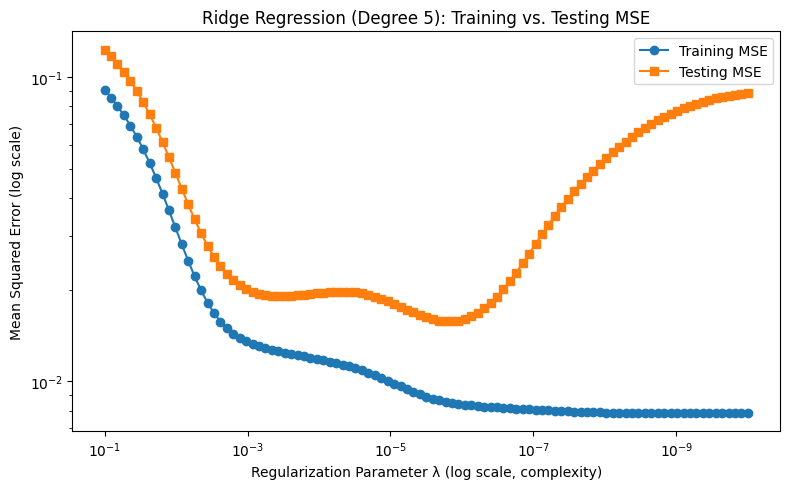

In [19]:
# Plot MSE vs. λ using log scales.
# Flipping the x-axis
  # so that models become more complex as we go from right to left.

# calculate average over all repeats for each lambda value 
mean_mse_train = np.mean(mse_train_errors, axis=0) 
mean_mse_test  = np.mean(mse_test_errors, axis=0)

plt.figure(figsize=(8,5))

# Plot training and testing curves without error bars
plt.plot(lambda_set, mean_mse_train, 'o-', label='Training MSE')
plt.plot(lambda_set, mean_mse_test, 's-', label='Testing MSE')

# Use log scales for both axes
plt.xscale('log')
plt.yscale('log')

# Flip the x-axis so that small values of λ (less regularization) are on the right
plt.gca().invert_xaxis()

plt.xlabel('Regularization Parameter λ (log scale, complexity)')
plt.ylabel('Mean Squared Error (log scale)')
plt.title('Ridge Regression (Degree 5): Training vs. Testing MSE')
plt.legend()
plt.tight_layout()
plt.show()

#### L2 Ridge Regression Performance with Different Lambda values

The graph above shows how the regularisation parameter ($\lambda$ i.e model complexity) in Ridge Regression impacts training and testing error for a degree 5 polynomial model

#### How Lambda Values Effect Model Complexity & Error:

* **Large $\lambda$, low complexity (@ Left Side): Strong Regularisation -> Underfitting**
    * Very simple model
    * High training error: Model doesn't capture data patterns well
    * High testing error: Poor generalisation due to too simple of a model

* **Small $\lambda$, high complexity (@ Right Side): Weak Regularisation -> Overfitting**
    * Very complex model
    * Low training error: Model overfits training data too closely (this includes noise)
    * High testing error: Bad generalisation as the model doesn't perform well on new data

* **Optimal $\lambda$ (Bottom of Testing MSE Curve): Balanced Complexity**
    * Achieves the lowest testing error
    * Is the best trade-off between fitting the data and generalising to unseen data (know when to stop training)
    * Based on the graph, good candidates for $\lambda$ could be $10^{-3}$ (more computationally efficient, more generalisable) or $10^{-6}$ (if maximal accuracy needed)

---

# Section 3 Bayes Classifier vs. Logistic Regression


## Question 5 (Generative vs. Discriminative Models)

### Part I
Load the dataset for breast cancer in sklearn.datasets

Use code from activity 3.3 for bayes classifier

Consider the Naive Bayes variant (without shared covariance) as well as the variants with full covariance (shared and not shared).

Do a training/test split (with train size equal to 0.8) and report which of the models performs best for train and test performance.


In [20]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# The class below does a bayesian classifier
  # shared against non-shared covariance matrices
  # bayes full covariance vs bayes naive (diagonal covariances)
class BayesianClassifier:
    def __init__(self, share_covariances=True, assume_conditional_independence=True):
        """
        Start bayes classifier with 2 bool flags:
          shared_variances (bool): if True - all classes share 1 covariance matrix
           assume_conditional_independence (bool): if True, coditional independence
                                                  (use diagonal covariance only)
        """
        self.share_covariances = share_covariances
        self.assume_conditional_independence = assume_conditional_independence

    def fit(self, training_data, training_labels):
        """
        Fit bayes classifier to training data.

        Params:
        training_data (array): Shape features (num_samples, num_features).
        training_labels (array): Shape labels (num_samples,).
        """
        # Extract unique class labels and their counts
        self.class_labels_, class_label_counts = np.unique(training_labels, return_counts=True)
        self.num_samples_, self.num_features_ = training_data.shape
        self.num_classes_ = len(self.class_labels_)

        # Initialise arrays to store mean vectors and covariance matrices for each class
        self.conditional_means_ = np.zeros((self.num_classes_, self.num_features_))
        self.conditional_covariances_ = np.zeros((self.num_classes_, self.num_features_, self.num_features_))

        # Compute class priors (probability of each class)
        self.class_priors_ = class_label_counts / len(training_labels)

        # Compute the mean and covariance for each class
        for class_index in range(self.num_classes_):
            class_rows = (training_labels == class_index) # selects only the classes being processed currently
            self.conditional_means_[class_index, :] = training_data[class_rows].mean(axis=0)

            if self.assume_conditional_independence:
                # Diagonal covariances only (naive Bayes)
                np.fill_diagonal(
                    self.conditional_covariances_[class_index, :, :],
                    training_data[class_rows].var(axis=0)
                )
            else:
                # Full covariance - features can correlate in the class
                self.conditional_covariances_[class_index, :, :] = np.cov(
                    training_data[class_rows].T,
                    bias=True
                )

        # If specified, share one covariance matrix across all classes (weighted by their priors)
        # computes weighted average of all covariances
        if self.share_covariances:
            weighted_covariance = np.moveaxis(self.conditional_covariances_, 0, -1).dot(self.class_priors_)
            # moveaxis changes shape so class axis is last to make weighted sum easier 
            # takes dot product for weighted average 
            self.conditional_covariances_[:] = weighted_covariance
            # assign this matrix to all classes 

        return self

    def predict_proba(self, new_data):
        """
        Compute posterior probabilities for each sample in new_data for every class.

        Params:
        new_data (array): Feature matrix of shape (num_samples, num_features).

        Returns:
        array: Posterior probabilities of shape (num_samples, num_classes).
        where entry [i,j] is likelihood of sample i under class j distribition
        """
        num_test_samples, _ = new_data.shape

        # Compute P(x|class) for each class
        conditional_probabilities = np.zeros((num_test_samples, self.num_classes_)) # empty matrix
        for class_index in range(self.num_classes_): # loop each class
            conditional_probabilities[:, class_index] = multivariate_normal.pdf( # calculates pdf for each sample batch
                new_data,
                mean=self.conditional_means_[class_index],
                cov=self.conditional_covariances_[class_index],
                allow_singular=True
            )

        # Marginal probabilities of x: sum over all classes
        marginal_probabilities = conditional_probabilities.dot(self.class_priors_)
        # prob of seeing the feature x regardless of class

        # Compute Bayes' rule: P(class|x) = [P(x|class)*P(class)] / P(x)
        posterior_probabilities = np.divide(
            (conditional_probabilities * self.class_priors_).T, # transpose to shape num_classes, num_samples - to divide w marginal
            marginal_probabilities,
            where=marginal_probabilities > 0,
            out=np.zeros((self.num_classes_, num_test_samples)) # preallocated array of 0s shape #class, #samples
        ).T


        return posterior_probabilities

    def predict(self, new_data):
        """
        Predict class with highest posterior probability.

        Params:
        new_data (array): Feature matrix of shape (num_samples, num_features).

        Returns:
        array: Predicted class labels (num_samples,).
        """
        return np.argmax(self.predict_proba(new_data), axis=1)

In [21]:
def part_I():
    # Load the breast cancer dataset
    breast_cancer_data = load_breast_cancer()
    features = breast_cancer_data.data
    labels = breast_cancer_data.target

    # Split into train and test sets
    features_train, features_test, labels_train, labels_test = train_test_split(
        features,
        labels,
        train_size=0.8,
        shuffle=True,
        random_state=0,
        stratify=labels
    )

    # Create different models
    log_reg_model = LogisticRegression(solver='lbfgs', max_iter=10000)
    bayes_classifier_naive = BayesianClassifier(share_covariances=False, assume_conditional_independence=True)
    bayes_classifier_full_not_shared = BayesianClassifier(share_covariances=False, assume_conditional_independence=False)
    bayes_classifier_full_shared = BayesianClassifier(share_covariances=True, assume_conditional_independence=False)

    # Fit models
    log_reg_model.fit(features_train, labels_train)
    bayes_classifier_naive.fit(features_train, labels_train)
    bayes_classifier_full_not_shared.fit(features_train, labels_train)
    bayes_classifier_full_shared.fit(features_train, labels_train)

    # Evaluate accuracy
    model_names = ["Logistic Regression", "Bayes Naive", "Bayes (Full Covariance)", "Bayes (Shared Covariance)"]
    models = [log_reg_model, bayes_classifier_naive, bayes_classifier_full_not_shared, bayes_classifier_full_shared]

    print("--- Test & Train Accuracy ---")
    for name, model in zip(model_names, models):
        train_predictions = model.predict(features_train)
        test_predictions = model.predict(features_test)
        train_accuracy = accuracy_score(labels_train, train_predictions)
        test_accuracy = accuracy_score(labels_test, test_predictions)
        print(f"{name}: Train Accuracy = {train_accuracy:.3f}, Test Accuracy = {test_accuracy:.3f}")
    print("-----------------------------\n")

part_I()

--- Test & Train Accuracy ---
Logistic Regression: Train Accuracy = 0.963, Test Accuracy = 0.947
Bayes Naive: Train Accuracy = 0.919, Test Accuracy = 0.904
Bayes (Full Covariance): Train Accuracy = 0.943, Test Accuracy = 0.912
Bayes (Shared Covariance): Train Accuracy = 0.965, Test Accuracy = 0.947
-----------------------------



## Model Performance Summary

| Model                      | Train Accuracy | Test Accuracy |
|----------------------------|---------------|---------------|
| Logistic Regression        | 0.963         | 0.947         |
| Bayes Naive                | 0.919         | 0.904         |
| Bayes (Full Covariance)    | 0.943         | 0.912         |
| Bayes (Shared Covariance)  | 0.965         | 0.947         |

### Best Train Accuracy
• Bayes (Shared Covariance) has the highest training accuracy (0.965).

### Best Test Accuracy
• Logistic Regression and Bayes (Shared Covariance) both tie at 0.947 for the highest test accuracy.

### Part II
Implement an experiment where you test the performance for increasing training sizes of
$N = 5, 10, . . . , 500$. For each N sample 10 training sets of the corresponding size, fit all
models, and record training and test errors.
Hints: You can use training test split from sklearn.model selection with an integer
parameter for train size (do not forget to use shuffle=True). Again make the repetitions
the inner loop to assure that all models are trained on the same training set for a given
repetition and sample size.

In [22]:
def part_II(): # Collect accuracies for the y-axis on the plot
    """
    For N in [5,10,15,...,500], sample 10 train sets of size N.
    Fit models. Record train/test accuracies.
    Return (train_sizes, train_acc_dict, test_acc_dict).
    """
    breast_cancer_data = load_breast_cancer()
    all_features = breast_cancer_data.data
    all_labels = breast_cancer_data.target

    # Helper function to get all models easily
    def get_all_models():
        return [
            ("LogReg", LogisticRegression(solver='lbfgs', max_iter=10000)),
            ("Naive Bayes", BayesianClassifier(share_covariances=False, assume_conditional_independence=True)),
            ("Bayes (Full Covariance)", BayesianClassifier(share_covariances=False, assume_conditional_independence=False)),
            ("Bayes (Shared Covariance)", BayesianClassifier(share_covariances=True, assume_conditional_independence=False))
        ]

    train_sizes_list = list(range(5, 501, 5))
    num_repetitions = 10

    # Prep dicts to store accuracies
    train_accuracies_dict = {name: [] for name, _ in get_all_models()}
    test_accuracies_dict = {name: [] for name, _ in get_all_models()}

    # Conduct experiments for each training set size
    for current_train_size in train_sizes_list:
        repetition_train_accs = {name: [] for name, _ in get_all_models()}
        repetition_test_accs = {name: [] for name, _ in get_all_models()}

        for _ in range(num_repetitions):
            if current_train_size < 2:
                continue

            # Split into train/test sets with the specified training size
            feat_train, feat_test, lbl_train, lbl_test = train_test_split(
                all_features,
                all_labels,
                train_size=current_train_size,
                shuffle=True,
                random_state=None,
                stratify=all_labels
            )

            # Ensure at least two classes exist in the training set
            if len(np.unique(lbl_train)) < 2:
                continue

            # Fit each model and record accuracy
            for model_name, model_object in get_all_models():
                model_object.fit(feat_train, lbl_train)
                train_accuracy = accuracy_score(lbl_train, model_object.predict(feat_train))
                test_accuracy = accuracy_score(lbl_test, model_object.predict(feat_test))
                repetition_train_accs[model_name].append(train_accuracy)
                repetition_test_accs[model_name].append(test_accuracy)

        # Average across all repetitions for this training size
        for name in repetition_train_accs.keys():
            if len(repetition_train_accs[name]) > 0:
                train_accuracies_dict[name].append(np.mean(repetition_train_accs[name]))
                test_accuracies_dict[name].append(np.mean(repetition_test_accs[name]))
            else:
                # Not enough data to form a valid training set
                train_accuracies_dict[name].append(np.nan)
                test_accuracies_dict[name].append(np.nan)

    return train_sizes_list, train_accuracies_dict, test_accuracies_dict


### Part III
Create suitable plots that compare the mean train and test performances of all models as a
function of training size. There is no need to include error bars if that makes the plot too
hard to read.

Generating Test and Train Accuracy
--- Test & Train Accuracy ---
Logistic Regression: Train Accuracy = 0.963, Test Accuracy = 0.947
Bayes Naive: Train Accuracy = 0.919, Test Accuracy = 0.904
Bayes (Full Covariance): Train Accuracy = 0.943, Test Accuracy = 0.912
Bayes (Shared Covariance): Train Accuracy = 0.965, Test Accuracy = 0.947
-----------------------------

Generating Plots, Please Wait. . .


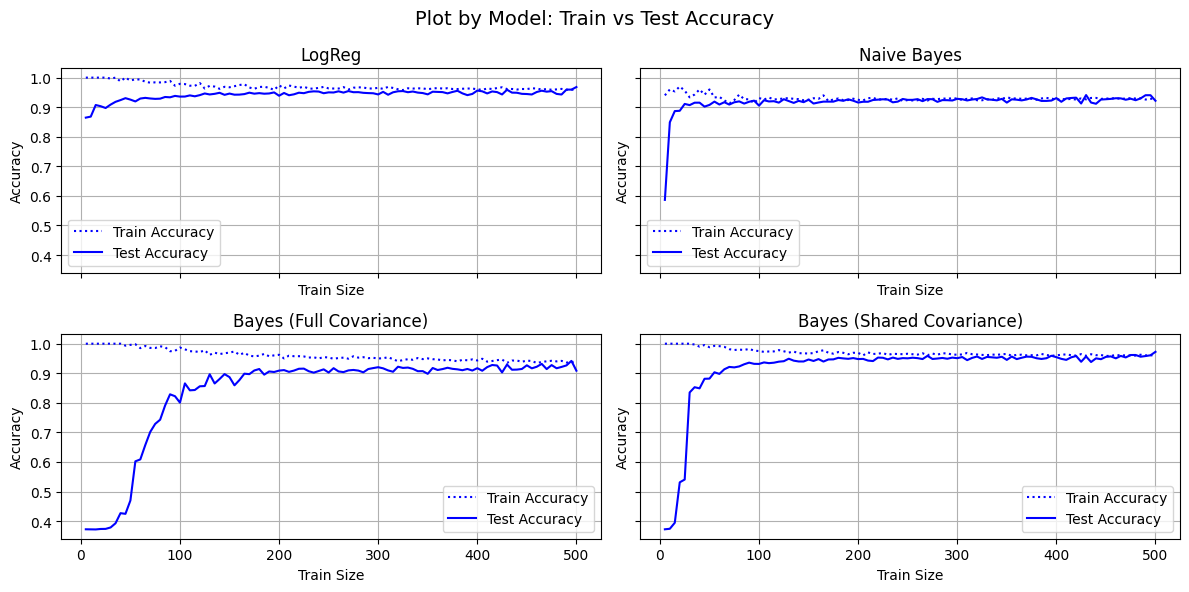

In [23]:
# Facet plot by model
# Plot accuracy. Test accuracy = solid line, Train accuracy = dotted.
def part_III():
    """
    Part III: Generate facet plots showing train vs test accuracy over varied train sizes.
    Uses the data collected by part_II and displays each model in a separate subplot.
    """
    train_sizes, train_acc_dict, test_acc_dict = part_II()
    model_names_list = list(train_acc_dict.keys())

    # Create subplots based on the number of models (2 columns)
    total_models = len(model_names_list)
    num_rows = int(np.ceil(total_models / 2))
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6), sharex=True, sharey=True)
    axes = axes.ravel()  # Flatten to make indexing easier

    # Plot each model in its own subplot
    for idx, model_name in enumerate(model_names_list):
        ax = axes[idx]
        # Dotted line for train accuracy
        ax.plot(train_sizes, train_acc_dict[model_name], linestyle=':', color='blue', label='Train Accuracy')
        # Solid line for test accuracy
        ax.plot(train_sizes, test_acc_dict[model_name], linestyle='-', color='blue', label='Test Accuracy')
        ax.set_title(model_name)
        ax.set_xlabel("Train Size")
        ax.set_ylabel("Accuracy")
        ax.legend()
        ax.grid(True)

    # Hide unused subplots if not all are used
    for remaining_index in range(idx + 1, len(axes)):
        axes[remaining_index].set_visible(False)

    fig.suptitle("Plot by Model: Train vs Test Accuracy", fontsize=14)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    print("Generating Test and Train Accuracy")
    part_I()

    print("Generating Plots, Please Wait. . .")
    part_III()

### Part IV
Answer the following:

#### Part a
What happens to each classifiers train and test performance when the number of training data points is increased?

From the plots, it appears that all 4 model's train accuracy decreased as the training size grew larger (indicates less overfitting). On the other hand, test accuracy improved and then plateaued (better generalisation) as the training size grew bigger.

It is possible with less data, models may have memorised traing example (since there was high training accuracy and low test accuracy to begin with). However, with more data they appeared to generalise better (shown by test accuracy improving).

#### Part b
Which classifier is best suited when the training set is small, and which is best suited
when the training set is big?

With smaller training data, simpler models like naive bayes and logistic regression appeared more accurate. They likely had fewer parameters to estimate to tended to overfit less. However,  when the training set was large, more flexible models like Bayes with full covariance, appeared to catch up or perform similarly, as there was enough data to estimate more parameters accurately.

#### Part c
Justify your observations by providing some speculations and possible reasons.

There were a few key points that justiy these obervsations (mostly based on model complexity and assumptions made):

* Naive Bayes (diagonal covariance) assumes strong independence and thus has fewer parameters, helping it do well with small data.

* Bayes with full covariance must learn many parameters, so it needs more data.

* Sharing covariance across classes reduces parameters somewhat, helping intermediate‐sized datasets.

* Logistic Regression's linear assumption typically generalises with moderate data requirements and can perform nicely across different sample sizes.